# CitiBike NYC - Exploratory Data Analysis

Understanding the data for building a Markovian random walk model to predict bike station flow.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

print("Libraries loaded successfully!")


Libraries loaded successfully!


## 1. Data Loading & Overview


In [2]:
# Define data paths
data_dir = Path('data')
sept_dir = data_dir / '202509-citibike-tripdata'
oct_dir = data_dir / '202510-citibike-tripdata'

# List all CSV files
sept_files = sorted(sept_dir.glob('*.csv'))
oct_files = sorted(oct_dir.glob('*.csv'))

print(f"September 2025 files: {len(sept_files)}")
for f in sept_files:
    print(f"  - {f.name}")

print(f"\nOctober 2025 files: {len(oct_files)}")
for f in oct_files:
    print(f"  - {f.name}")


September 2025 files: 6
  - 202509-citibike-tripdata_1.csv
  - 202509-citibike-tripdata_2.csv
  - 202509-citibike-tripdata_3.csv
  - 202509-citibike-tripdata_4.csv
  - 202509-citibike-tripdata_5.csv
  - 202509-citibike-tripdata_6.csv

October 2025 files: 5
  - 202510-citibike-tripdata_1.csv
  - 202510-citibike-tripdata_2.csv
  - 202510-citibike-tripdata_3.csv
  - 202510-citibike-tripdata_4.csv
  - 202510-citibike-tripdata_5.csv


In [3]:
# Load all data
def load_all_data(file_list):
    """Load and concatenate all CSV files."""
    dfs = []
    for f in tqdm(file_list, desc="Loading files"):
        df = pd.read_csv(f)
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

# Load September and October data
print("Loading September data...")
df_sept = load_all_data(sept_files)
print(f"September: {len(df_sept):,} trips")

print("\nLoading October data...")
df_oct = load_all_data(oct_files)
print(f"October: {len(df_oct):,} trips")

# Combine both months
df = pd.concat([df_sept, df_oct], ignore_index=True)
print(f"\nTotal: {len(df):,} trips")


Loading September data...


Loading files: 100%|██████████| 6/6 [00:10<00:00,  1.74s/it]


September: 5,287,447 trips

Loading October data...


Loading files: 100%|██████████| 5/5 [00:09<00:00,  1.98s/it]


October: 4,731,900 trips

Total: 10,019,347 trips


In [4]:
# Basic info
print("Dataset Shape:", df.shape)
print("\nColumn Types:")
print(df.dtypes)
print("\nFirst few rows:")
df.head()


Dataset Shape: (10019347, 13)

Column Types:
ride_id                object
rideable_type          object
started_at             object
ended_at               object
start_station_name     object
start_station_id       object
end_station_name       object
end_station_id         object
start_lat             float64
start_lng             float64
end_lat               float64
end_lng               float64
member_casual          object
dtype: object

First few rows:


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,C849A925DD4E562F,electric_bike,2025-09-13 17:15:03.997,2025-09-13 17:37:45.524,Allen St & Rivington St,5414.06,Nassau Ave & Newell St,5623.03,40.720196,-73.989978,40.724813,-73.947526,member
1,519EC702D7A15805,electric_bike,2025-09-04 07:43:58.415,2025-09-04 07:55:26.708,E 10 St & 2 Ave,5746.02,W 43 St & 6 Ave,6593.14,40.729708,-73.986598,40.755273,-73.983169,member
2,7D370F14765D5BC7,electric_bike,2025-09-11 00:08:47.799,2025-09-11 00:18:19.022,Marcus Garvey Blvd & Macon St,4278.03,Fulton St & Clermont Ave,4386.05,40.682601,-73.938037,40.684157,-73.969223,member
3,E0ACBC585B9C89AF,classic_bike,2025-09-09 19:17:04.216,2025-09-09 19:28:13.073,India St Pier,5794.05,Frost St & Meeker Ave,5371.07,40.731735,-73.961239,40.717662,-73.948800,member
4,3F8591CF28972E36,electric_bike,2025-09-14 13:51:38.237,2025-09-14 13:57:22.168,Calyer St & West St,5676.04,Nassau Ave & Newell St,5623.03,40.726930,-73.958630,40.724813,-73.947526,member


In [5]:
# Check for missing values
print("Missing Values:")
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({'Count': missing, 'Percentage': missing_pct})
print(missing_df[missing_df['Count'] > 0])

print(f"\nTotal rows: {len(df):,}")
print(f"Rows with any missing: {df.isnull().any(axis=1).sum():,}")


Missing Values:
                    Count  Percentage
start_station_name   5261        0.05
start_station_id     5261        0.05
end_station_name    22961        0.23
end_station_id      25932        0.26
start_lat            5261        0.05
start_lng            5261        0.05
end_lat             25911        0.26
end_lng             25911        0.26

Total rows: 10,019,347
Rows with any missing: 30,436


In [6]:
# Convert timestamps
df['started_at'] = pd.to_datetime(df['started_at'])
df['ended_at'] = pd.to_datetime(df['ended_at'])

# Calculate trip duration in minutes
df['duration_min'] = (df['ended_at'] - df['started_at']).dt.total_seconds() / 60

# Extract time features
df['hour'] = df['started_at'].dt.hour
df['day_of_week'] = df['started_at'].dt.dayofweek  # 0=Monday, 6=Sunday
df['day_name'] = df['started_at'].dt.day_name()
df['date'] = df['started_at'].dt.date
df['is_weekend'] = df['day_of_week'].isin([5, 6])

print("Time features extracted!")
print(f"\nDate range: {df['started_at'].min()} to {df['started_at'].max()}")


Time features extracted!

Date range: 2025-08-30 23:27:40.264000 to 2025-10-31 23:58:16.325000


## 2. Trip Duration Analysis


In [7]:
# Duration statistics
print("Trip Duration Statistics (minutes):")
print(df['duration_min'].describe())

# Check for anomalies
print(f"\nNegative durations: {(df['duration_min'] < 0).sum():,}")
print(f"Zero durations: {(df['duration_min'] == 0).sum():,}")
print(f"Trips > 1 hour: {(df['duration_min'] > 60).sum():,}")
print(f"Trips > 24 hours: {(df['duration_min'] > 1440).sum():,}")


Trip Duration Statistics (minutes):
count    1.001935e+07
mean     1.311235e+01
std      2.716601e+01
min      1.000400e+00
25%      5.454433e+00
50%      9.280283e+00
75%      1.580232e+01
max      1.545452e+03
Name: duration_min, dtype: float64

Negative durations: 0
Zero durations: 0
Trips > 1 hour: 85,102
Trips > 24 hours: 1,708


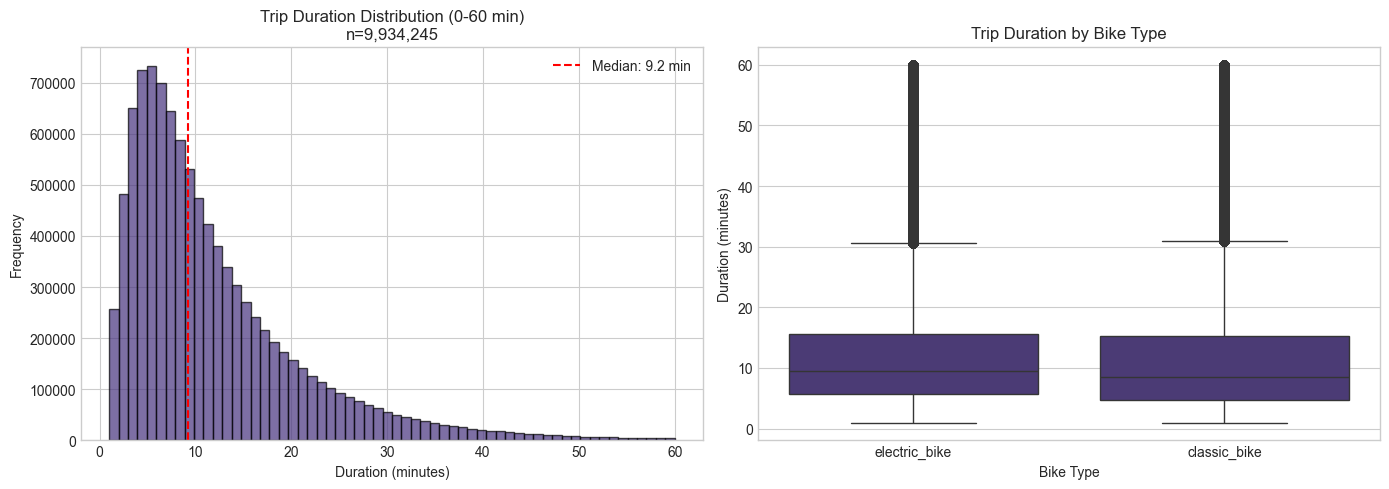

In [8]:
# Distribution of trip durations (filtering outliers for visualization)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of reasonable durations (0-60 min)
reasonable_durations = df[(df['duration_min'] > 0) & (df['duration_min'] <= 60)]['duration_min']
axes[0].hist(reasonable_durations, bins=60, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Duration (minutes)')
axes[0].set_ylabel('Frequency')
axes[0].set_title(f'Trip Duration Distribution (0-60 min)\nn={len(reasonable_durations):,}')
axes[0].axvline(reasonable_durations.median(), color='red', linestyle='--', label=f'Median: {reasonable_durations.median():.1f} min')
axes[0].legend()

# Box plot by bike type
df_filtered = df[(df['duration_min'] > 0) & (df['duration_min'] <= 60)]
sns.boxplot(data=df_filtered, x='rideable_type', y='duration_min', ax=axes[1])
axes[1].set_xlabel('Bike Type')
axes[1].set_ylabel('Duration (minutes)')
axes[1].set_title('Trip Duration by Bike Type')

plt.tight_layout()
plt.show()


## 3. Station Analysis


In [16]:
# Count unique stations (using station NAMES to avoid duplicate ID issues)
print(f"Unique start station names: {df['start_station_name'].nunique():,}")
print(f"Unique end station names: {df['end_station_name'].nunique():,}")

# All unique station names
all_station_names = set(df['start_station_name'].dropna().unique()) | set(df['end_station_name'].dropna().unique())
print(f"Total unique stations (by name): {len(all_station_names):,}")

# Note: Using names instead of IDs because the same physical station can have multiple IDs


Unique start station names: 2,183
Unique end station names: 2,253
Total unique stations (by name): 2,253


In [17]:
# Departures and arrivals per station (using station NAMES)
departures = df.groupby('start_station_name').size()
arrivals = df.groupby('end_station_name').size()

# Get all unique station names
all_stations = set(departures.index) | set(arrivals.index)
print(f"Processing {len(all_stations):,} unique stations...")

# Create station stats DataFrame with explicit index
station_stats = pd.DataFrame(index=list(all_stations))
station_stats['departures'] = departures.reindex(station_stats.index).fillna(0).astype(int)
station_stats['arrivals'] = arrivals.reindex(station_stats.index).fillna(0).astype(int)
station_stats['total_trips'] = station_stats['departures'] + station_stats['arrivals']
station_stats['net_flow'] = station_stats['arrivals'] - station_stats['departures']
station_stats = station_stats.sort_values('total_trips', ascending=False)

print("Top 15 busiest stations:")
print(station_stats.head(15))


Processing 2,253 unique stations...
Top 15 busiest stations:
                          departures  arrivals  total_trips  net_flow
W 21 St & 6 Ave                37266     37354        74620        88
Lafayette St & E 8 St          33112     33238        66350       126
West St & Chambers St          32632     32732        65364       100
Pier 61 at Chelsea Piers       31314     31379        62693        65
9 Ave & W 33 St                30188     30482        60670       294
University Pl & E 14 St        29726     30049        59775       323
Broadway & E 14 St             29744     29770        59514        26
W 31 St & 7 Ave                29515     29571        59086        56
E 17 St & Broadway             28571     28764        57335       193
Broadway & W 58 St             28836     28362        57198      -474
Central Park S & 6 Ave         28048     28083        56131        35
11 Ave & W 41 St               28013     27735        55748      -278
Cleveland Pl & Spring St     

In [18]:
# Top 20 busiest stations (index is already station name now!)
print("Top 20 busiest stations:")
print(station_stats[['departures', 'arrivals', 'net_flow']].head(20).to_string())


Top 20 busiest stations:
                          departures  arrivals  net_flow
W 21 St & 6 Ave                37266     37354        88
Lafayette St & E 8 St          33112     33238       126
West St & Chambers St          32632     32732       100
Pier 61 at Chelsea Piers       31314     31379        65
9 Ave & W 33 St                30188     30482       294
University Pl & E 14 St        29726     30049       323
Broadway & E 14 St             29744     29770        26
W 31 St & 7 Ave                29515     29571        56
E 17 St & Broadway             28571     28764       193
Broadway & W 58 St             28836     28362      -474
Central Park S & 6 Ave         28048     28083        35
11 Ave & W 41 St               28013     27735      -278
Cleveland Pl & Spring St       27150     27266       116
W 30 St & 10 Ave               27055     27070        15
Broadway & W 25 St             26886     26962        76
6 Ave & W 33 St                27216     26586      -630
8 Ave 

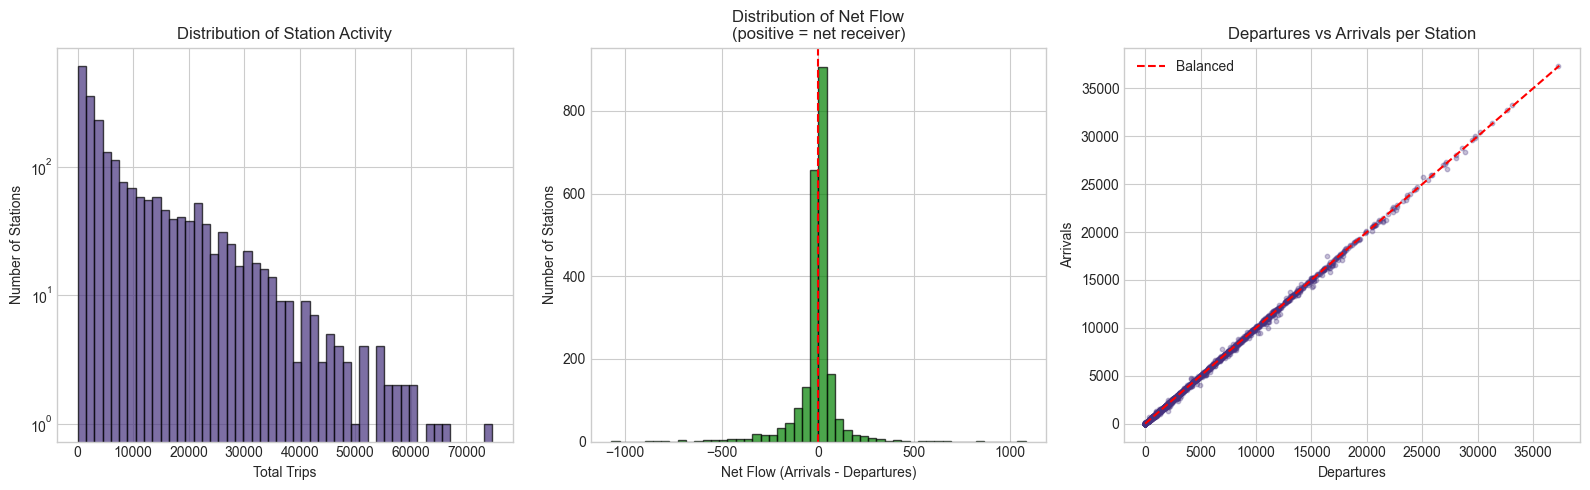

In [19]:
# Distribution of station activity
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Total trips distribution
axes[0].hist(station_stats['total_trips'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Total Trips')
axes[0].set_ylabel('Number of Stations')
axes[0].set_title('Distribution of Station Activity')
axes[0].set_yscale('log')

# Net flow distribution
axes[1].hist(station_stats['net_flow'], bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1].axvline(0, color='red', linestyle='--')
axes[1].set_xlabel('Net Flow (Arrivals - Departures)')
axes[1].set_ylabel('Number of Stations')
axes[1].set_title('Distribution of Net Flow\n(positive = net receiver)')

# Scatter plot: departures vs arrivals
axes[2].scatter(station_stats['departures'], station_stats['arrivals'], alpha=0.3, s=10)
max_val = max(station_stats['departures'].max(), station_stats['arrivals'].max())
axes[2].plot([0, max_val], [0, max_val], 'r--', label='Balanced')
axes[2].set_xlabel('Departures')
axes[2].set_ylabel('Arrivals')
axes[2].set_title('Departures vs Arrivals per Station')
axes[2].legend()

plt.tight_layout()
plt.show()


In [20]:
# Stations with most imbalanced flow
print("Top 10 NET RECEIVERS (more arrivals):")
print(station_stats.nlargest(10, 'net_flow')[['departures', 'arrivals', 'net_flow']].to_string())

print("\nTop 10 NET SENDERS (more departures):")
print(station_stats.nsmallest(10, 'net_flow')[['departures', 'arrivals', 'net_flow']].to_string())


Top 10 NET RECEIVERS (more arrivals):
                               departures  arrivals  net_flow
Greenwich St & W Houston St         16378     17457      1079
Kent Ave & N 3 St                    6924      7783       859
Norfolk St & Broome St              25094     25769       675
Driggs Ave & N 9 St                 13054     13696       642
Pioneer St & Van Brunt St            4160      4726       566
Van Brunt St & Wolcott St            4114      4639       525
Washington St & Barrow St            8375      8836       461
North Moore St & Greenwich St       14094     14525       431
Forsyth St & Broome St               7886      8290       404
W Broadway & Spring St              12726     13117       391

Top 10 NET SENDERS (more departures):
                               departures  arrivals  net_flow
Plaza St East & Flatbush Ave        11037      9965     -1072
Broadway & W 56 St                  11805     10760     -1045
E 35 St & Madison Ave               10381      9490    

In [21]:
# Data Quality Note: Same station can have multiple IDs in CitiBike data
# We use station NAMES instead of IDs to avoid this issue

# Show how many unique IDs map to each station name
id_mapping = df[['start_station_name', 'start_station_id']].drop_duplicates()
ids_per_name = id_mapping.groupby('start_station_name')['start_station_id'].nunique()
multi_id_stations = ids_per_name[ids_per_name > 1].sort_values(ascending=False)

print(f"Stations with multiple IDs: {len(multi_id_stations):,} out of {len(ids_per_name):,} unique names")
print(f"\nTop 10 stations with most IDs:")
print(multi_id_stations.head(10))
print("\nNote: Using station NAMES consolidates these correctly!")


Stations with multiple IDs: 4 out of 2,183 unique names

Top 10 stations with most IDs:
start_station_name
Clinton St & Grand St    2
Kent Ave & N 3 St        2
W 35 St & 9 Ave          2
W 42 St & 6 Ave          2
Name: start_station_id, dtype: int64

Note: Using station NAMES consolidates these correctly!


In [38]:
# Create a mapping from station name to average coordinates (for geographic analysis later)
# We take the mean lat/lng across all IDs for each station name
# Filter out invalid coordinates (0.0 or outside NYC bounds)

# NYC bounding box (approximate)
NYC_LAT_MIN, NYC_LAT_MAX = 40.4, 41.0
NYC_LNG_MIN, NYC_LNG_MAX = -74.3, -73.6

# Filter to valid coordinates before aggregating
df_valid_coords = df[
    (df['start_lat'] > NYC_LAT_MIN) & (df['start_lat'] < NYC_LAT_MAX) &
    (df['start_lng'] > NYC_LNG_MIN) & (df['start_lng'] < NYC_LNG_MAX)
]

station_coords = df_valid_coords.groupby('start_station_name').agg({
    'start_lat': 'mean',
    'start_lng': 'mean'
}).rename(columns={'start_lat': 'lat', 'start_lng': 'lng'})

# Add coordinates from end stations for stations that only appear as destinations
df_valid_end_coords = df[
    (df['end_lat'] > NYC_LAT_MIN) & (df['end_lat'] < NYC_LAT_MAX) &
    (df['end_lng'] > NYC_LNG_MIN) & (df['end_lng'] < NYC_LNG_MAX)
]

end_coords = df_valid_end_coords.groupby('end_station_name').agg({
    'end_lat': 'mean',
    'end_lng': 'mean'
}).rename(columns={'end_lat': 'lat', 'end_lng': 'lng'})

# Combine (prioritize start coords, fill missing with end coords)
station_coords = station_coords.combine_first(end_coords)

print(f"Stations with valid coordinates: {len(station_coords):,}")
print(f"\nCoordinate ranges (NYC only):")
print(f"  Latitude: {station_coords['lat'].min():.4f} to {station_coords['lat'].max():.4f}")
print(f"  Longitude: {station_coords['lng'].min():.4f} to {station_coords['lng'].max():.4f}")


Stations with valid coordinates: 2,250

Coordinate ranges (NYC only):
  Latitude: 40.6202 to 40.8863
  Longitude: -74.0784 to -73.8467


## 4. Temporal Patterns


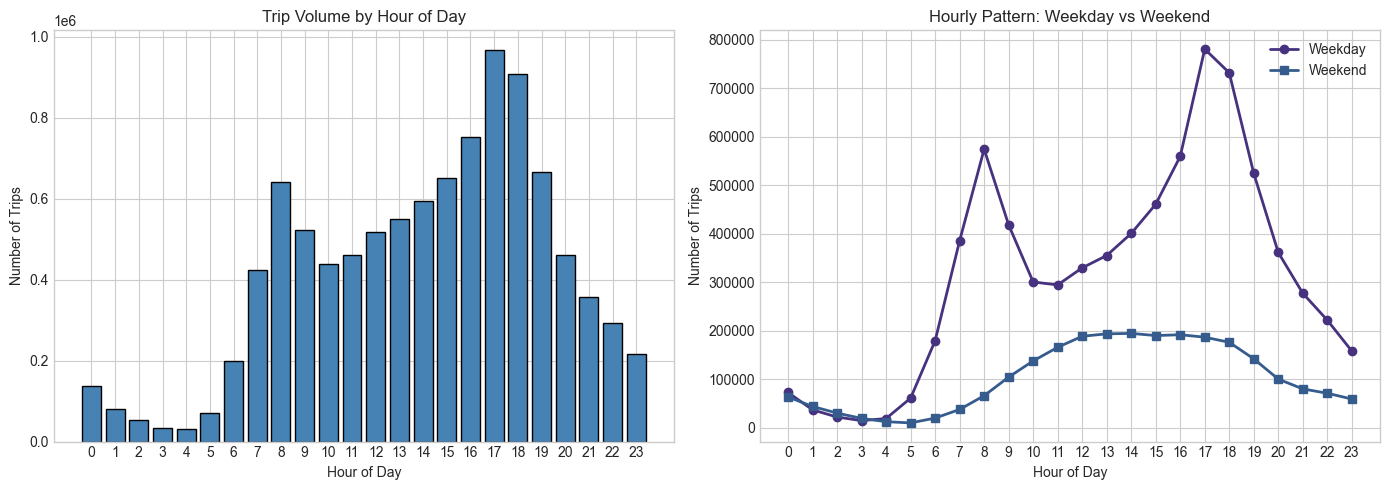

In [23]:
# Trips by hour of day
hourly_trips = df.groupby('hour').size()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall hourly pattern
axes[0].bar(hourly_trips.index, hourly_trips.values, color='steelblue', edgecolor='black')
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Number of Trips')
axes[0].set_title('Trip Volume by Hour of Day')
axes[0].set_xticks(range(0, 24))

# Weekday vs Weekend hourly pattern
hourly_weekday = df[~df['is_weekend']].groupby('hour').size()
hourly_weekend = df[df['is_weekend']].groupby('hour').size()

axes[1].plot(hourly_weekday.index, hourly_weekday.values, 'o-', label='Weekday', linewidth=2)
axes[1].plot(hourly_weekend.index, hourly_weekend.values, 's-', label='Weekend', linewidth=2)
axes[1].set_xlabel('Hour of Day')
axes[1].set_ylabel('Number of Trips')
axes[1].set_title('Hourly Pattern: Weekday vs Weekend')
axes[1].set_xticks(range(0, 24))
axes[1].legend()

plt.tight_layout()
plt.show()


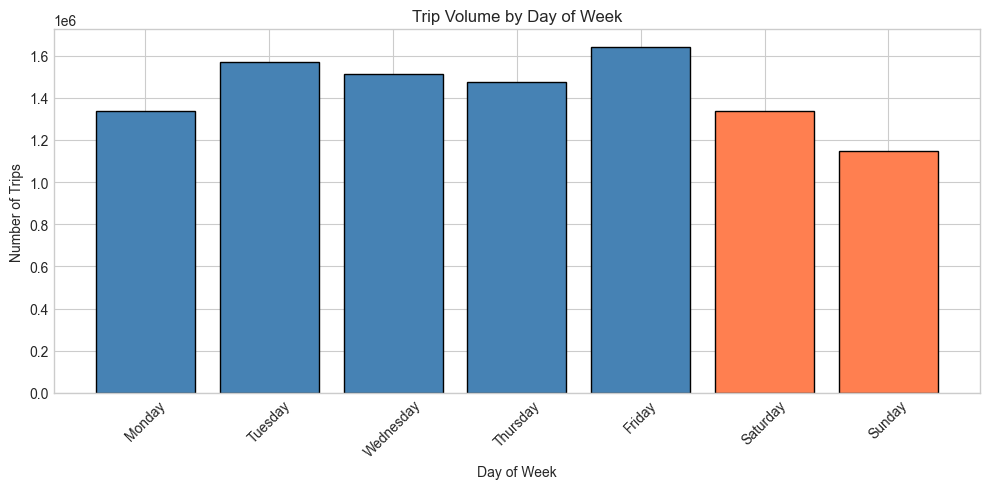

In [24]:
# Trips by day of week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_trips = df.groupby('day_name').size().reindex(day_order)

plt.figure(figsize=(10, 5))
colors = ['steelblue']*5 + ['coral']*2  # Different color for weekends
plt.bar(daily_trips.index, daily_trips.values, color=colors, edgecolor='black')
plt.xlabel('Day of Week')
plt.ylabel('Number of Trips')
plt.title('Trip Volume by Day of Week')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


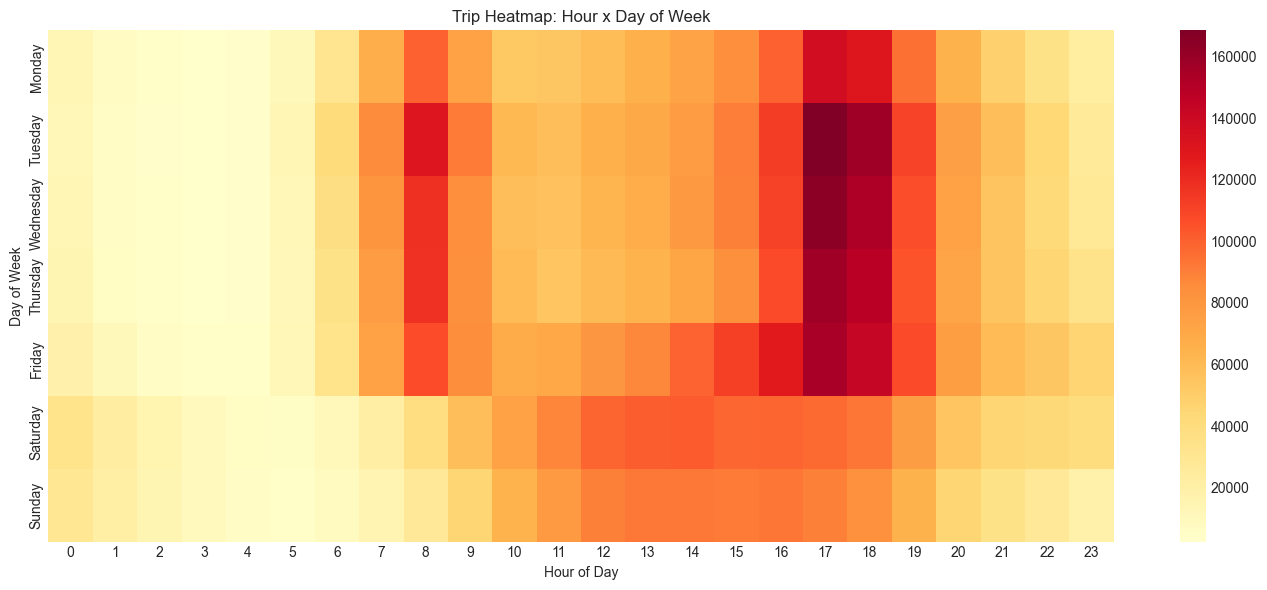

In [25]:
# Heatmap: Hour x Day of Week
pivot_hourday = df.groupby(['day_of_week', 'hour']).size().unstack(fill_value=0)
pivot_hourday.index = day_order

plt.figure(figsize=(14, 6))
sns.heatmap(pivot_hourday, cmap='YlOrRd', annot=False)
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.title('Trip Heatmap: Hour x Day of Week')
plt.tight_layout()
plt.show()


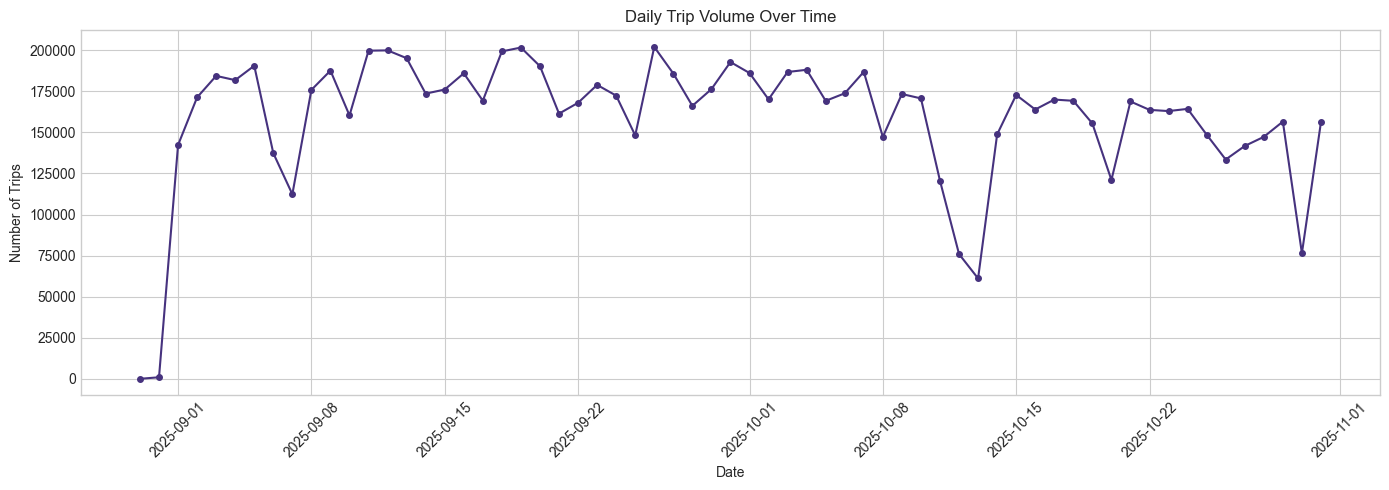


Daily trip statistics:
count        63.000000
mean     159037.253968
std       40970.229663
min           2.000000
25%      148688.500000
50%      169310.000000
75%      185120.500000
max      202031.000000
dtype: float64


In [26]:
# Daily trip counts over time
daily_counts = df.groupby('date').size()

plt.figure(figsize=(14, 5))
plt.plot(daily_counts.index, daily_counts.values, 'o-', markersize=4)
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.title('Daily Trip Volume Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"\nDaily trip statistics:")
print(daily_counts.describe())


## 5. Bike Type & User Analysis


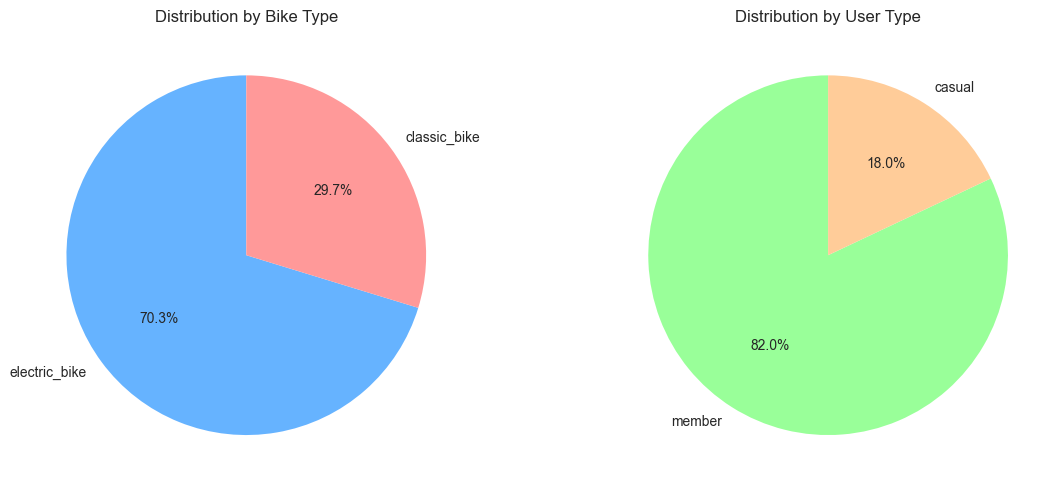

Bike Type Counts:
rideable_type
electric_bike    7040813
classic_bike     2978534
Name: count, dtype: int64

Member Type Counts:
member_casual
member    8217740
casual    1801607
Name: count, dtype: int64


In [27]:
# Bike type distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Pie chart - bike type
bike_counts = df['rideable_type'].value_counts()
axes[0].pie(bike_counts.values, labels=bike_counts.index, autopct='%1.1f%%', 
            colors=['#66b3ff', '#ff9999'], startangle=90)
axes[0].set_title('Distribution by Bike Type')

# Pie chart - member type
member_counts = df['member_casual'].value_counts()
axes[1].pie(member_counts.values, labels=member_counts.index, autopct='%1.1f%%',
            colors=['#99ff99', '#ffcc99'], startangle=90)
axes[1].set_title('Distribution by User Type')

plt.tight_layout()
plt.show()

print("Bike Type Counts:")
print(bike_counts)
print("\nMember Type Counts:")
print(member_counts)


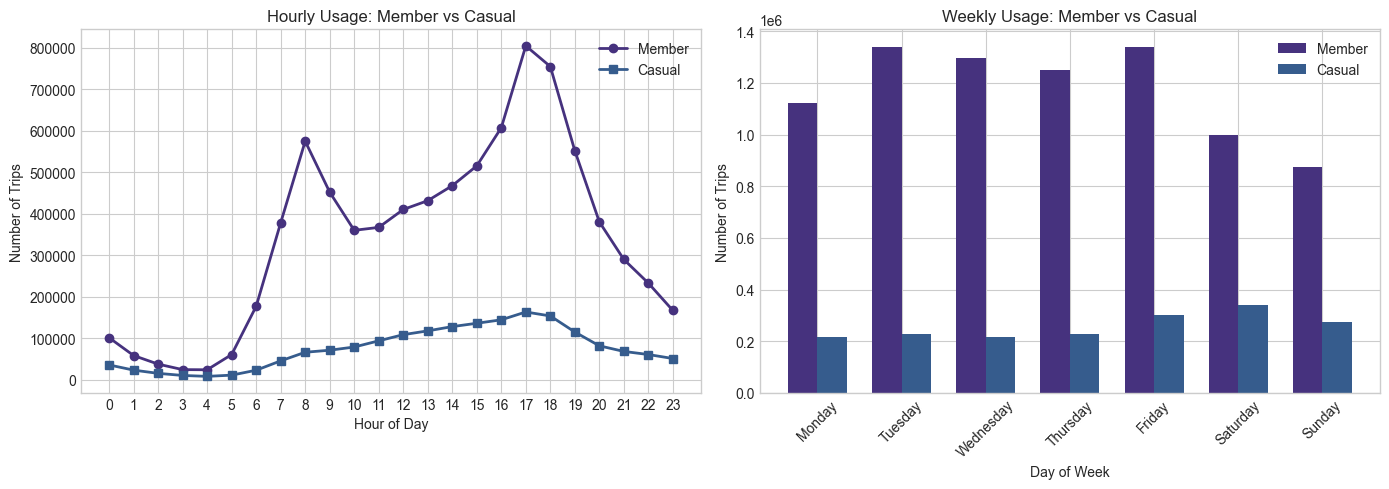

In [28]:
# Usage patterns by user type
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Hourly pattern by user type
hourly_member = df[df['member_casual'] == 'member'].groupby('hour').size()
hourly_casual = df[df['member_casual'] == 'casual'].groupby('hour').size()

axes[0].plot(hourly_member.index, hourly_member.values, 'o-', label='Member', linewidth=2)
axes[0].plot(hourly_casual.index, hourly_casual.values, 's-', label='Casual', linewidth=2)
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Number of Trips')
axes[0].set_title('Hourly Usage: Member vs Casual')
axes[0].legend()
axes[0].set_xticks(range(0, 24))

# Day of week pattern by user type
dow_member = df[df['member_casual'] == 'member'].groupby('day_name').size().reindex(day_order)
dow_casual = df[df['member_casual'] == 'casual'].groupby('day_name').size().reindex(day_order)

x = np.arange(len(day_order))
width = 0.35
axes[1].bar(x - width/2, dow_member.values, width, label='Member')
axes[1].bar(x + width/2, dow_casual.values, width, label='Casual')
axes[1].set_xlabel('Day of Week')
axes[1].set_ylabel('Number of Trips')
axes[1].set_title('Weekly Usage: Member vs Casual')
axes[1].set_xticks(x)
axes[1].set_xticklabels(day_order, rotation=45)
axes[1].legend()

plt.tight_layout()
plt.show()


## 6. Station-to-Station Transitions (Key for Markov Model)


In [29]:
# Filter to valid station pairs (using station NAMES)
df_valid = df.dropna(subset=['start_station_name', 'end_station_name']).copy()
print(f"Trips with valid station pairs: {len(df_valid):,} ({len(df_valid)/len(df)*100:.1f}%)")

# Count transitions by station name
transitions = df_valid.groupby(['start_station_name', 'end_station_name']).size().reset_index(name='count')
print(f"\nUnique station pairs (transitions): {len(transitions):,}")
print(f"\nTransition count statistics:")
print(transitions['count'].describe())


Trips with valid station pairs: 9,991,868 (99.7%)

Unique station pairs (transitions): 923,090

Transition count statistics:
count    923090.000000
mean         10.824370
std          28.545312
min           1.000000
25%           1.000000
50%           3.000000
75%           8.000000
max        4273.000000
Name: count, dtype: float64


In [30]:
# Self-loops (round trips to same station)
self_loops = transitions[transitions['start_station_name'] == transitions['end_station_name']]
print(f"Self-loops (same start/end station): {len(self_loops):,} unique stations")
print(f"Total self-loop trips: {self_loops['count'].sum():,}")
print(f"Percentage of all trips: {self_loops['count'].sum() / len(df_valid) * 100:.2f}%")


Self-loops (same start/end station): 2,175 unique stations
Total self-loop trips: 188,430
Percentage of all trips: 1.89%


In [31]:
# Most common routes (already using station names!)
top_routes = transitions.nlargest(20, 'count').copy()

print("Top 20 most common routes:")
print(top_routes.to_string())


Top 20 most common routes:
                   start_station_name             end_station_name  count
268287         Central Park S & 6 Ave       Central Park S & 6 Ave   4273
128756     7 Ave & Central Park South   7 Ave & Central Park South   2591
109829           55 Ave & Center Blvd         Vernon Blvd & 50 Ave   1830
798735           Vernon Blvd & 50 Ave         55 Ave & Center Blvd   1779
724121       Roosevelt Island Tramway     Roosevelt Island Tramway   1613
467643        Franklin St & Dupont St         Jackson Ave & 49 Ave   1541
744496               Soissons Landing             Soissons Landing   1526
537535           Jackson Ave & 49 Ave      Franklin St & Dupont St   1403
649019           N 6 St & Bedford Ave            S 2 St & Kent Ave   1374
903740          West St & Chambers St  Pier 40 - Hudson River Park   1362
661596  North Moore St & Greenwich St      Vesey St & Greenwich St   1335
649023           N 6 St & Bedford Ave           S 4 St & Wythe Ave   1333
726379     

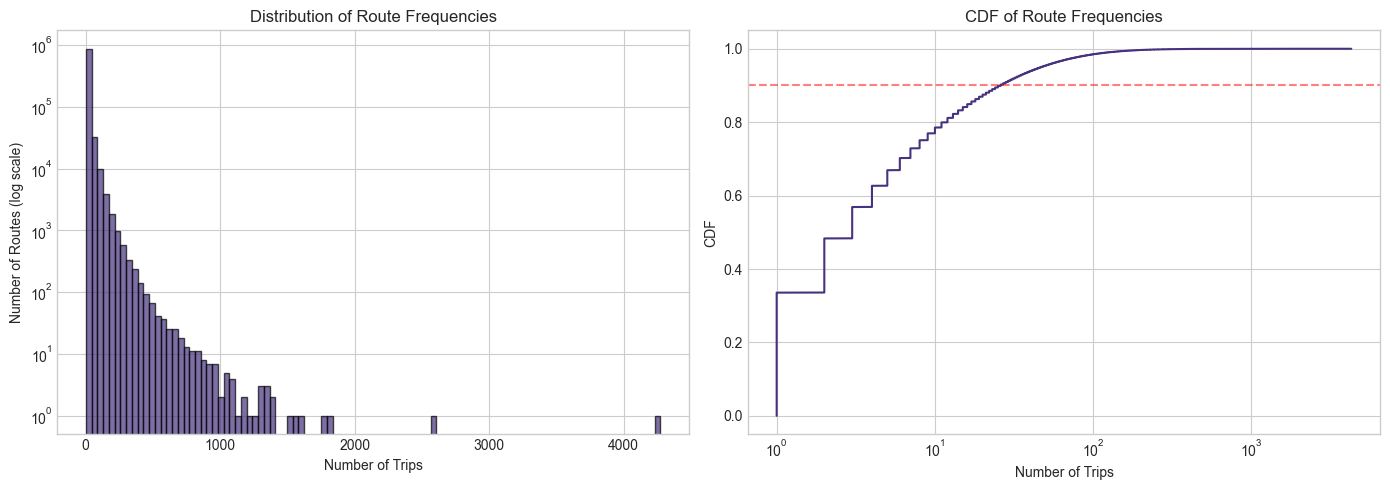

50% of trips covered by 55,296 routes (6.0% of all routes)
80% of trips covered by 203,121 routes (22.0% of all routes)
90% of trips covered by 353,023 routes (38.2% of all routes)
95% of trips covered by 518,381 routes (56.2% of all routes)


In [32]:
# Distribution of transition frequencies
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Log scale histogram
axes[0].hist(transitions['count'], bins=100, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Number of Trips')
axes[0].set_ylabel('Number of Routes (log scale)')
axes[0].set_title('Distribution of Route Frequencies')
axes[0].set_yscale('log')

# CDF
sorted_counts = np.sort(transitions['count'].values)
cdf = np.arange(1, len(sorted_counts) + 1) / len(sorted_counts)
axes[1].plot(sorted_counts, cdf)
axes[1].set_xlabel('Number of Trips')
axes[1].set_ylabel('CDF')
axes[1].set_title('CDF of Route Frequencies')
axes[1].axhline(0.9, color='red', linestyle='--', alpha=0.5)
axes[1].set_xscale('log')

plt.tight_layout()
plt.show()

# What percentage of routes account for X% of trips?
transitions_sorted = transitions.sort_values('count', ascending=False)
transitions_sorted['cumsum'] = transitions_sorted['count'].cumsum()
transitions_sorted['cum_pct'] = transitions_sorted['cumsum'] / transitions_sorted['count'].sum()

for pct in [0.5, 0.8, 0.9, 0.95]:
    n_routes = (transitions_sorted['cum_pct'] <= pct).sum() + 1
    print(f"{pct*100:.0f}% of trips covered by {n_routes:,} routes ({n_routes/len(transitions)*100:.1f}% of all routes)")


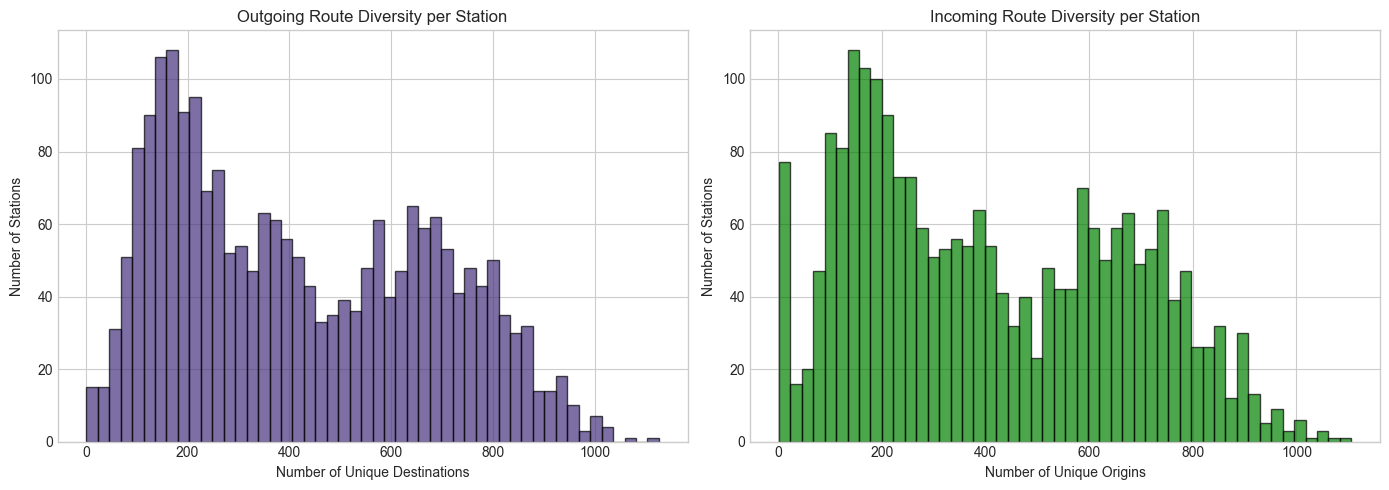

Outgoing diversity - Mean: 422.9, Max: 1126
Incoming diversity - Mean: 409.7, Max: 1106


In [33]:
# Number of outgoing destinations per station
outgoing_diversity = transitions.groupby('start_station_name')['end_station_name'].nunique()

# Number of incoming origins per station
incoming_diversity = transitions.groupby('end_station_name')['start_station_name'].nunique()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(outgoing_diversity, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Number of Unique Destinations')
axes[0].set_ylabel('Number of Stations')
axes[0].set_title('Outgoing Route Diversity per Station')

axes[1].hist(incoming_diversity, bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1].set_xlabel('Number of Unique Origins')
axes[1].set_ylabel('Number of Stations')
axes[1].set_title('Incoming Route Diversity per Station')

plt.tight_layout()
plt.show()

print(f"Outgoing diversity - Mean: {outgoing_diversity.mean():.1f}, Max: {outgoing_diversity.max()}")
print(f"Incoming diversity - Mean: {incoming_diversity.mean():.1f}, Max: {incoming_diversity.max()}")


## 7. Geographic Distribution


In [39]:
# Create station location dataframe with activity (using station names)
# Merge coordinates with station stats
station_locs = station_stats.join(station_coords, how='left')

# Drop stations without valid coordinates
station_locs = station_locs.dropna(subset=['lat', 'lng'])

# Additional filter to ensure all coords are within NYC bounds
station_locs = station_locs[
    (station_locs['lat'] > NYC_LAT_MIN) & (station_locs['lat'] < NYC_LAT_MAX) &
    (station_locs['lng'] > NYC_LNG_MIN) & (station_locs['lng'] < NYC_LNG_MAX)
]

print(f"Stations with valid NYC coordinates: {len(station_locs):,}")
print(f"\nCoordinate ranges:")
print(f"  Latitude: {station_locs['lat'].min():.4f} to {station_locs['lat'].max():.4f}")
print(f"  Longitude: {station_locs['lng'].min():.4f} to {station_locs['lng'].max():.4f}")


Stations with valid NYC coordinates: 2,250

Coordinate ranges:
  Latitude: 40.6202 to 40.8863
  Longitude: -74.0784 to -73.8467


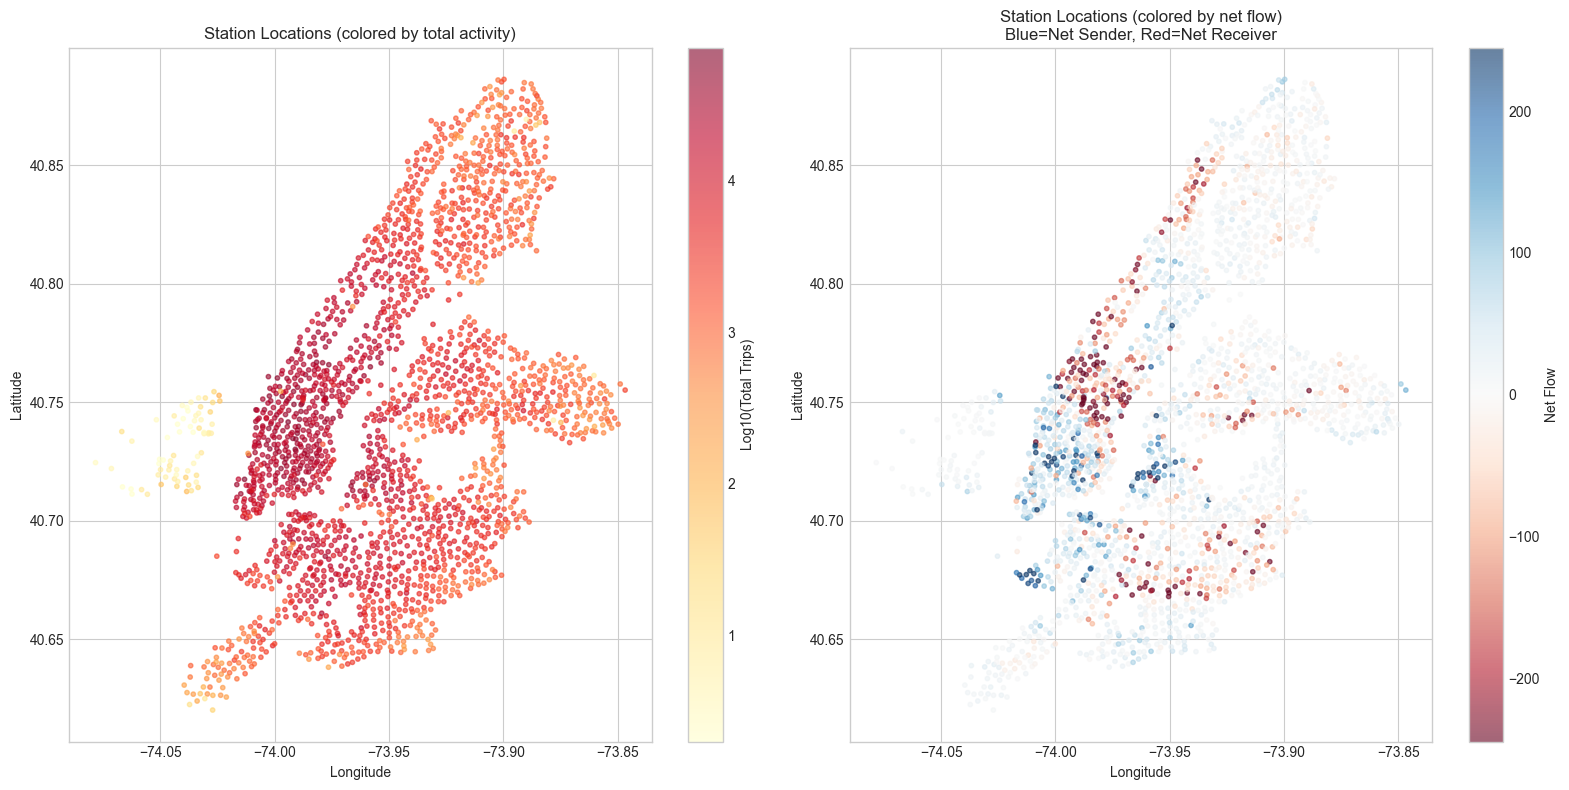

In [40]:
# Scatter plot of stations
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Colored by total activity
scatter1 = axes[0].scatter(
    station_locs['lng'], station_locs['lat'],
    c=np.log10(station_locs['total_trips'] + 1),
    s=10, alpha=0.6, cmap='YlOrRd'
)
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].set_title('Station Locations (colored by total activity)')
plt.colorbar(scatter1, ax=axes[0], label='Log10(Total Trips)')

# Colored by net flow
scatter2 = axes[1].scatter(
    station_locs['lng'], station_locs['lat'],
    c=station_locs['net_flow'],
    s=10, alpha=0.6, cmap='RdBu', vmin=-station_locs['net_flow'].abs().quantile(0.95), 
    vmax=station_locs['net_flow'].abs().quantile(0.95)
)
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
axes[1].set_title('Station Locations (colored by net flow)\nBlue=Net Sender, Red=Net Receiver')
plt.colorbar(scatter2, ax=axes[1], label='Net Flow')

plt.tight_layout()
plt.show()


## 8. Transition Matrix Preview (for Markov Model)


In [41]:
# For the Markov model, we need to think about:
# 1. State space (stations)
# 2. Transition probabilities

# Let's look at a subset of popular stations to visualize
top_n = 30
top_stations = station_stats.nlargest(top_n, 'total_trips').index.tolist()

# Filter transitions to top stations only
transitions_top = transitions[
    (transitions['start_station_name'].isin(top_stations)) & 
    (transitions['end_station_name'].isin(top_stations))
]

print(f"Transitions between top {top_n} stations: {len(transitions_top):,}")
print(f"Total trips in this subset: {transitions_top['count'].sum():,}")


Transitions between top 30 stations: 897
Total trips in this subset: 122,244


In [42]:
# Create transition matrix
transition_matrix = transitions_top.pivot(
    index='start_station_name', 
    columns='end_station_name', 
    values='count'
).fillna(0)

# Normalize rows to get probabilities
transition_probs = transition_matrix.div(transition_matrix.sum(axis=1), axis=0)

print(f"Transition matrix shape: {transition_matrix.shape}")
print(f"\nSample transition probabilities from first station ({transition_probs.index[0]}):")
first_station = transition_probs.index[0]
probs = transition_probs.loc[first_station].sort_values(ascending=False).head(10)
print(probs)


Transition matrix shape: (30, 30)

Sample transition probabilities from first station (1 Ave & E 68 St):
end_station_name
1 Ave & E 68 St           0.153209
E 33 St & 1 Ave           0.105590
Central Park S & 6 Ave    0.083506
W 31 St & 7 Ave           0.079365
Broadway & W 58 St        0.077985
6 Ave & W 33 St           0.076605
W 41 St & 8 Ave           0.075914
Park Ave & E 42 St        0.071084
9 Ave & W 33 St           0.039337
W 21 St & 6 Ave           0.037957
Name: 1 Ave & E 68 St, dtype: float64


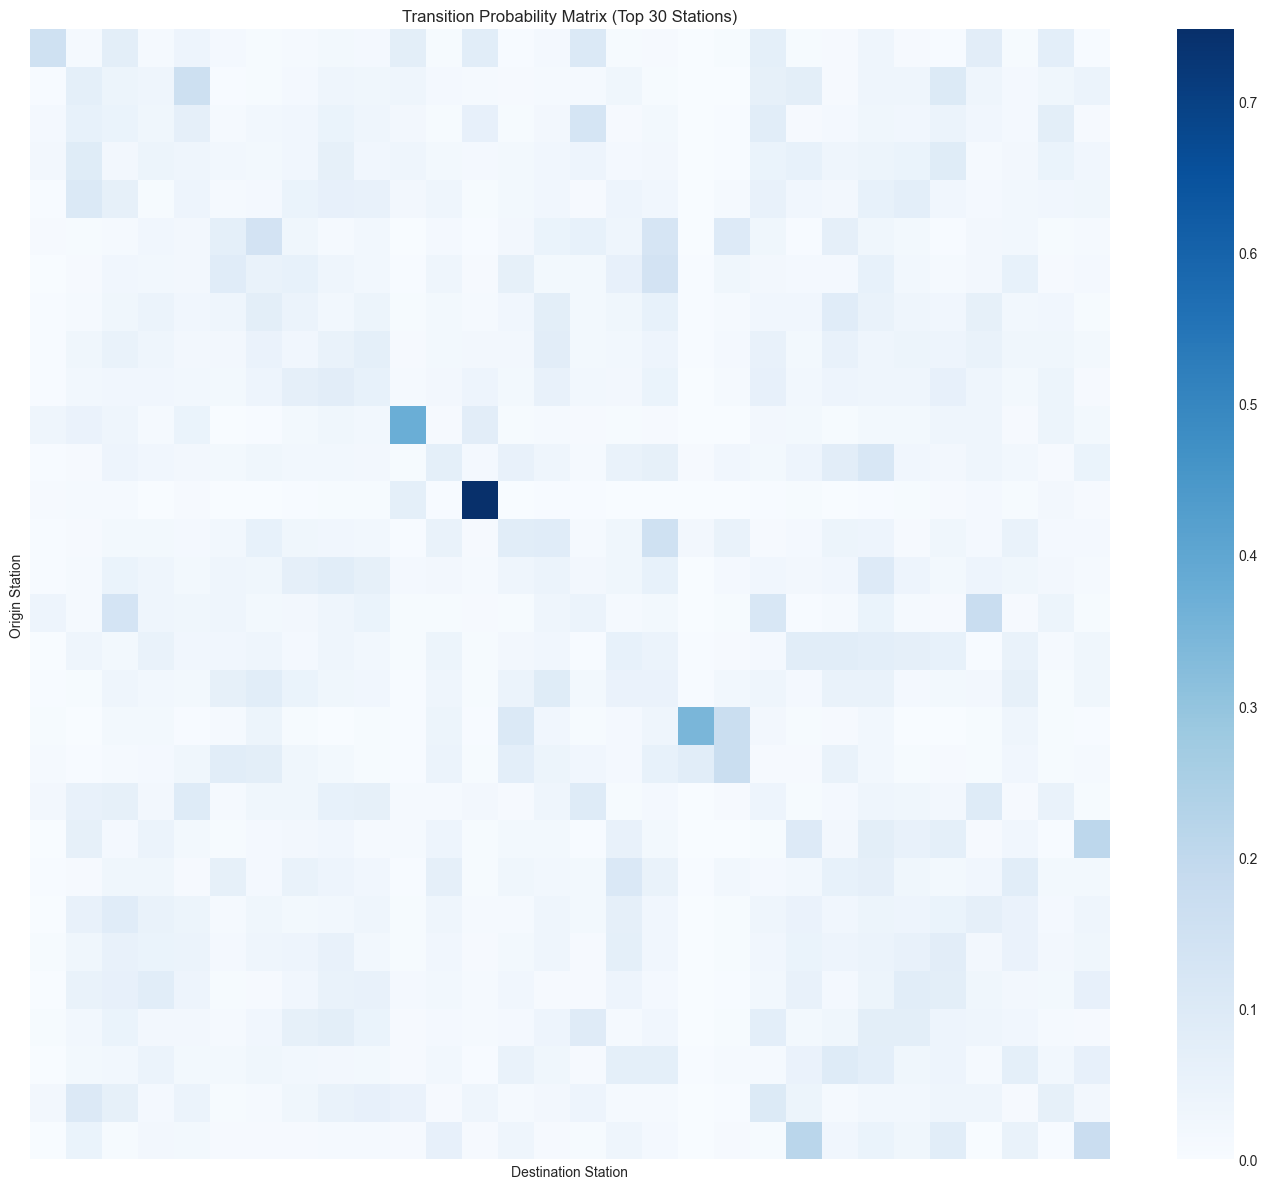

In [43]:
# Visualize transition matrix heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(
    transition_probs, 
    cmap='Blues',
    xticklabels=False,
    yticklabels=False
)
plt.xlabel('Destination Station')
plt.ylabel('Origin Station')
plt.title(f'Transition Probability Matrix (Top {top_n} Stations)')
plt.tight_layout()
plt.show()


In [44]:
# Sparsity of full transition matrix
n_stations = len(all_station_names)
n_possible_transitions = n_stations ** 2
n_observed_transitions = len(transitions)

print(f"Total stations (by name): {n_stations:,}")
print(f"Possible transitions (n²): {n_possible_transitions:,}")
print(f"Observed transitions: {n_observed_transitions:,}")
print(f"Sparsity: {(1 - n_observed_transitions/n_possible_transitions)*100:.2f}%")
print(f"\nThis means the full transition matrix would be {100 - (1 - n_observed_transitions/n_possible_transitions)*100:.2f}% dense")


Total stations (by name): 2,253
Possible transitions (n²): 5,076,009
Observed transitions: 923,090
Sparsity: 81.81%

This means the full transition matrix would be 18.19% dense


## 9. Summary & Key Insights for Markov Modeling


In [45]:
print("="*60)
print("EDA SUMMARY FOR MARKOV MODEL")
print("="*60)

print(f"\n📊 DATA OVERVIEW:")
print(f"   - Total trips: {len(df):,}")
print(f"   - Date range: {df['started_at'].min().date()} to {df['started_at'].max().date()}")
print(f"   - Total unique stations (by name): {len(all_station_names):,}")
print(f"   - Unique routes observed: {len(transitions):,}")

print(f"\n🚲 TRIP CHARACTERISTICS:")
print(f"   - Electric bikes: {(df['rideable_type']=='electric_bike').sum():,} ({(df['rideable_type']=='electric_bike').mean()*100:.1f}%)")
print(f"   - Classic bikes: {(df['rideable_type']=='classic_bike').sum():,} ({(df['rideable_type']=='classic_bike').mean()*100:.1f}%)")
print(f"   - Members: {(df['member_casual']=='member').sum():,} ({(df['member_casual']=='member').mean()*100:.1f}%)")
print(f"   - Casual: {(df['member_casual']=='casual').sum():,} ({(df['member_casual']=='casual').mean()*100:.1f}%)")
print(f"   - Median trip duration: {df['duration_min'].median():.1f} minutes")

print(f"\n⏰ TEMPORAL PATTERNS:")
print(f"   - Peak hours: 8-9 AM and 5-6 PM (commuting)")
print(f"   - Weekday vs Weekend: Different patterns observed")
print(f"   - Members: Commuter-like pattern (peaks at rush hours)")
print(f"   - Casual: More uniform, peaks on weekends")

print(f"\n🗺️ NETWORK CHARACTERISTICS:")
print(f"   - Transition matrix sparsity: {(1 - n_observed_transitions/n_possible_transitions)*100:.1f}%")
print(f"   - Self-loops (round trips): {self_loops['count'].sum():,} ({self_loops['count'].sum()/len(df_valid)*100:.1f}%)")
print(f"   - Avg outgoing destinations per station: {outgoing_diversity.mean():.1f}")
print(f"   - Avg incoming origins per station: {incoming_diversity.mean():.1f}")

print(f"\n⚠️ CONSIDERATIONS FOR MODELING:")
print(f"   - State space: {len(all_station_names)} stations (using names, not IDs)")
print(f"   - Time-varying behavior (weekday/weekend, hour of day)")
print(f"   - Imbalanced stations (net senders vs receivers)")
print(f"   - Missing station data: {df['start_station_name'].isnull().sum() + df['end_station_name'].isnull().sum():,} entries")
print(f"   - Consider: time-homogeneous vs time-inhomogeneous Markov chain")


EDA SUMMARY FOR MARKOV MODEL

📊 DATA OVERVIEW:
   - Total trips: 10,019,347
   - Date range: 2025-08-30 to 2025-10-31
   - Total unique stations (by name): 2,253
   - Unique routes observed: 923,090

🚲 TRIP CHARACTERISTICS:
   - Electric bikes: 7,040,813 (70.3%)
   - Classic bikes: 2,978,534 (29.7%)
   - Members: 8,217,740 (82.0%)
   - Casual: 1,801,607 (18.0%)
   - Median trip duration: 9.3 minutes

⏰ TEMPORAL PATTERNS:
   - Peak hours: 8-9 AM and 5-6 PM (commuting)
   - Weekday vs Weekend: Different patterns observed
   - Members: Commuter-like pattern (peaks at rush hours)
   - Casual: More uniform, peaks on weekends

🗺️ NETWORK CHARACTERISTICS:
   - Transition matrix sparsity: 81.8%
   - Self-loops (round trips): 188,430 (1.9%)
   - Avg outgoing destinations per station: 422.9
   - Avg incoming origins per station: 409.7

⚠️ CONSIDERATIONS FOR MODELING:
   - State space: 2253 stations (using names, not IDs)
   - Time-varying behavior (weekday/weekend, hour of day)
   - Imbalanced s